
# Base Imports

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [3]:
import pyrosetta.distributed

In [4]:
import tmol.tests.data

In [5]:
import tmol.system.io
import tmol.score
import torch
import tmol.score.ljlk.jit_score_graph
import tmol.score.ljlk.cpp_potential

In [6]:
from tmol.utility.reactive import reactive_attrs, reactive_property

# Rosetta Scoring

Benchmark rosetta scoring performance by structure size.

In [7]:
import toolz

In [8]:
decoys = toolz.keyfilter(lambda k: k<500, tmol.tests.data.structures_bysize())

In [9]:
from tmol.tests.benchmark import subfixture, make_subfixture, make_fixture, stat_frame, stat_profile

torch.set_num_threads(1)

rosetta_score_results = []
scores = {}
profiles = {}

for dsize, d in decoys.items():
    model_name = f"BYSIZE_{dsize}"

    work_pose = d.stripped_pose.pose

    logging.info(dsize)

    fixture = make_fixture(
        "score",
        rosetta_score_results.append,
        nres=len(work_pose.residues),
        natoms=len(d.tmol_coords),
        model=model_name,
        max_time=.25,
        use_cprofile=True,
        
    )

    logging.info("Rosetta")
    atr_rep_sf = pyrosetta.get_score_function()
    for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
        if k not in ("fa_atr", "fa_rep"):
            atr_rep_sf.set_weight(v, 0)

    @subfixture(fixture, impl="rosetta", device="cpu")
    def rosetta_atr_rep():
        work_pose.energies().clear()
        return atr_rep_sf(work_pose)
    
    @reactive_attrs
    class TMolJitLJLK(
        tmol.score.ljlk.jit_score_graph.JitLJLKScoreGraph,
        tmol.score.coordinates.CartesianAtomicCoordinateProvider,
        tmol.score.bonded_atom.BondedAtomScoreGraph,
        tmol.score.device.TorchDevice,
    ):
        pass

    score_graphs = dict(
        tmol_lj_cpu_cpp=TMolJitLJLK.build_for(
            d.tmol_system, requires_grad=False, lj_jit_type="cpp"
        )
    )

    for n, sg in score_graphs.items():
        logging.info(f"{n}")
        # Setup graph
        sg.intra_score().total_lj

        for ptype in tmol.score.ljlk.cpp_potential.potentials:
            tmol.score.ljlk.cpp_potential.POTENTIAL_SET = ptype

            gfix = make_subfixture(
                fixture, f".{n}.{ptype}", impl=ptype, device=sg.device.type
            )

            @gfix
            def benchmark_score_graph():
                sg.coords = sg.coords
                return sg.intra_score().total_lj

            scores.setdefault(model_name, {})[gfix.name] = benchmark_score_graph

    del score_graphs
    torch.cuda.empty_cache()

    tmol_scores = " ".join(f"{n}: {v}" for n, v in scores[model_name].items())

    logging.info(f"rosetta: {rosetta_atr_rep} {tmol_scores}")


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:levels all:warning'}
INFO:root:100
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -440.40303847870354 score.tmol_lj_cpu_cpp.blocked: tensor([-370.7062]) score.tmol_lj_cpu_cpp.naive: tensor([-370.7062])
INFO:root:150
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -752.441272221159 score.tmol_lj_cpu_cpp.blocked: tensor([-353.4837]) score.tmol_lj_cpu_cpp.naive: tensor([-353.4837])
INFO:root:40
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -174.25545026564072 score.tmol_lj_cpu_cpp.blocked: tensor([-152.2725]) score.tmol_lj_cpu_cpp.naive: tensor([-152.2725])
INFO:root:75
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -291.7034003587354 score.tmol_lj_cpu_cpp.blocked: tensor([430.5983]) score.tmol_lj_cpu_cpp.naive: tensor([430.5983])
INFO:root:55
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_cpp
INFO:root:rosetta: -159.61986092225598 sco

In [10]:
import pandas

In [11]:
import altair
altair.themes.register("vis", lambda: dict(config={
        "view": {"height": 500, "width": 800},
        "axis": {"labelFontSize": 16, "titleFontSize": 16},
        "legend": {"labelFontSize": 16, "titleFontSize": 16},
        "header": {"labelFontSize": 16, "titleFontSize": 16},
        "title": {"fontSize": 16},
    }))
altair.themes.enable("vis")
altair.data_transformers.enable('default', max_rows=20e3)

pass

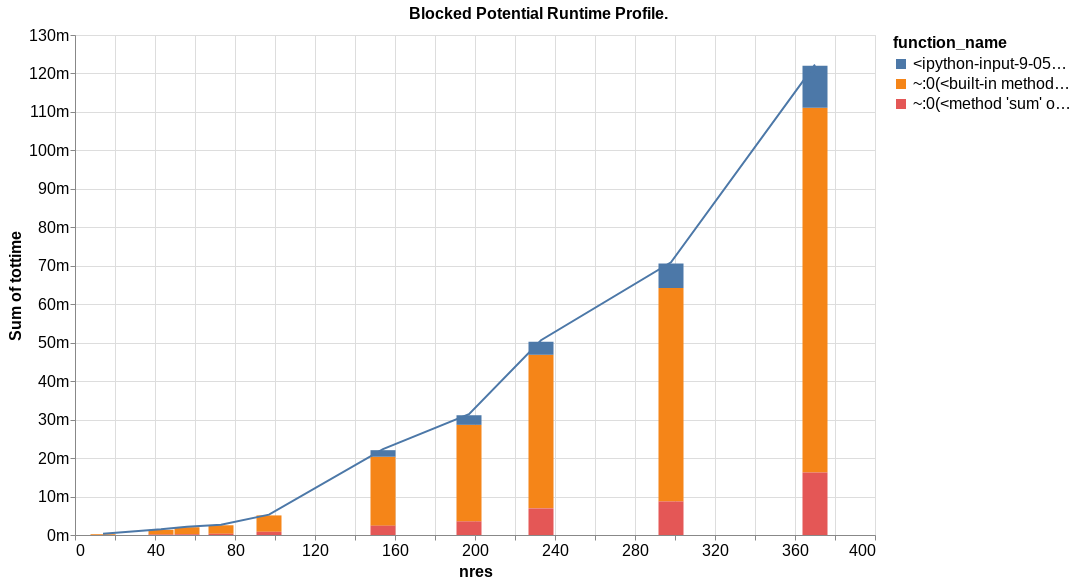

In [12]:
pdat = stat_profile(rosetta_score_results)
pdat = pdat.query("impl != 'rosetta'").query("impl=='blocked'")
rdat = pdat.query("tottime > 100e-6 and fractime > 1e-3")

encoding = dict(
    x="nres",
    y=altair.Y("sum(tottime)", axis=altair.Axis(format="s")),
    color="function_name",
)

c = (
    altair.Chart(rdat).mark_bar().encode(**encoding)
    + altair.Chart(pdat).mark_line().encode(x="nres", y="sum(tottime)")
).configure(bar={"continuousBandSize": 25})
c.title="Blocked Potential Runtime Profile."
c

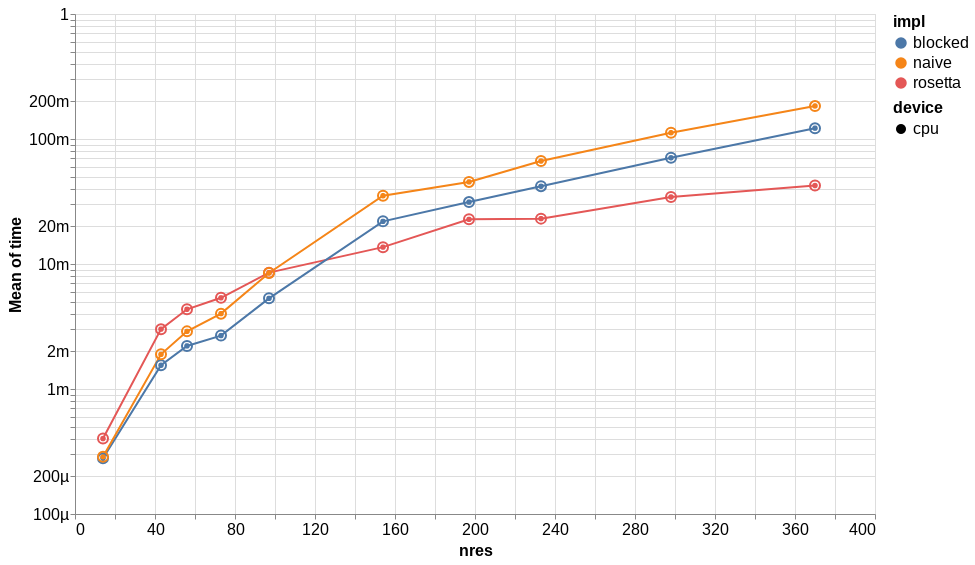

In [13]:
dat = stat_frame(rosetta_score_results)
dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'score.rosetta_atr_rep'").groupby("model").time.mean().rename("rosetta_mean").to_frame(),
            left_on="model",
            right_index=True
        ).eval("time / rosetta_mean").rename("rosetta_relative")
    ),
    axis=1
)

encoding = dict(
        x="nres",
        y=altair.Y(
            "mean(time)",
            scale=altair.Scale(type="log", base=10),
            axis=altair.Axis(format="s"),
        ),
        color="impl",
        shape="device",
)

c = (
    altair.Chart(dat)
    .mark_line()
    .encode(**encoding)
     +
    altair.Chart(dat)
    .mark_point(size=100)
    .encode(**encoding)
)
c

In [14]:
display((
    dat.query("name=='score.rosetta_atr_rep'")
    .groupby("natoms")[["time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
))

display((dat
    .groupby(("natoms", "name"))[["rosetta_relative", "time"]]
    .describe()
    .reorder_levels((1, 0), axis=1)["mean"]
    .xs("score.tmol_lj_cpu_cpp.blocked", level=1)
    .eval("fold_acceleration = rosetta_relative ** -1")
))

,mean,max,std
,time,time,time
natoms,,,
264,0.000401,0.000564,0.000018
816,0.003011,0.004272,0.000254
1080,0.004342,0.006778,0.000474
1368,0.005363,0.008029,0.000578
1864,0.008529,0.008778,0.000107
3016,0.013639,0.013961,0.000144
3600,0.022754,0.028147,0.004380
4128,0.023065,0.023466,0.000183


,rosetta_relative,time,fold_acceleration
natoms,,,
264,0.695702,0.000279,1.437397
816,0.514354,0.001549,1.944187
1080,0.509240,0.002211,1.963711
1368,0.498777,0.002675,2.004904
1864,0.622520,0.005310,1.606374
3016,1.608075,0.021932,0.621862
3600,1.374844,0.031283,0.727355
4128,1.814635,0.041854,0.551075
5408,2.058665,0.070736,0.485752
